In [2]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

palette = ["#2E610F", "#D9443D", "#7F5072", "#CFA97C", "#43383D"]

sns.set_style("ticks")
sns.set_palette(palette, 5)

# Data preprocessing

In [3]:
mirror_x_min = 175
mirror_x_max = 535
mirror_y_min = 90
mirror_y_max = 360
front_x_min = 545
front_x_max = 1380
front_y_min = 410
front_y_max = 680

video_conditions = pd.DataFrame.from_dict({1: [4, 20, 4],
                                           2: [4, 20, 6],
                                           3: [4, 30, 4],
                                           4: [4, 30, 6],
                                           5: [4, 40, 4],
                                           6: [4, 40, 6],
                                           7: [6, 20, 4],
                                           8: [6, 20, 6],
                                           9: [6, 30, 4],
                                           10: [6, 30, 6],
                                           11: [6, 40, 4],
                                           12: [6, 40, 6]}, 
                                          orient="index", columns=["time_budget", "d", "tta"])
video_conditions.index.name = "video"

In [4]:
raw_data_path = "D:\surfdrive\data\Merijn\data\Part%i\Output\Results_xy.txt"
participant_dfs = []

# participants 1 and 2 are excluded because ...
for participant_id in range(3, 27):
    # print(participant_id)
    participant_df = pd.read_csv(raw_data_path % participant_id, sep="\t", low_memory=False)
    # For now, ignore fine-grained data on eye movements during one frame, get the first instance per frame only
    participant_df = participant_df.groupby(["TRIAL_INDEX", "VIDEO_FRAME_INDEX"]).first().reset_index()
    participant_df["participant"] = participant_id
    
    # participant 17's data misses video number and frame index
    
    if not participant_id==17:
        participant_dfs.append(participant_df)

data = pd.concat(participant_dfs)

data["VIDEO_FRAME_INDEX"] = pd.to_numeric(data["VIDEO_FRAME_INDEX"], errors='coerce')
data = data.dropna(subset=["VIDEO_FRAME_INDEX"])
data.loc[:, "VIDEO_FRAME_INDEX"] = data["VIDEO_FRAME_INDEX"].astype("Int64")
data["AVERAGE_GAZE_X"] = pd.to_numeric(data["AVERAGE_GAZE_X"], errors='coerce')
data["AVERAGE_GAZE_Y"] = pd.to_numeric(data["AVERAGE_GAZE_Y"], errors='coerce')

# exclude 5 trials with no indicated decisions
data = data[~(data["VARIABLE_Key_Pressed"]==".")]
data = data.rename(columns={"TRIAL_INDEX": "trial", "VARIABLE_RT": "RT", "AVERAGE_GAZE_X": "eye_x", "AVERAGE_GAZE_Y": "eye_y"})
# in the EyeLink coordinate system, the origin is in the top left corner; for intuitive plotting we place the origin in the bottom left corner
data["eye_y"] = (1080 - data["eye_y"]) 
# with the framerate of 20 frames/s (each frame presented for 50ms), time can be calculated from the frame number 
data["t"] = data["VIDEO_FRAME_INDEX"]*0.05
data["video"] = data["VIDEO_NAME"].str.extract('(\d+)').astype("Int64")

# Option 1: use AOI information recorded in EyeLink software
# Here, 1 is mirror, 2 is front view, NaN is elsewhere
# data["AOI"] = data["AVERAGE_INTEREST_AREAS"].str.extract('(\d+)').astype("Int64")
# data["AOI"] == data.AOI.replace({np.NaN: "other", 1: "mirror", 2:"front"}) 

# Option 2: use manually configured AOI
data["AOI"] = "other"
data.loc[(data.eye_x>mirror_x_min) & (data.eye_x<mirror_x_max) & (data.eye_y>mirror_y_min) & (data.eye_y<mirror_y_max), "AOI"] = "mirror"
data.loc[(data.eye_x>front_x_min) & (data.eye_x<front_x_max) & (data.eye_y>front_y_min) & (data.eye_y<front_y_max), "AOI"] = "front"

data["is_looking_elsewhere"] = data["AOI"] == "other"
data["is_looking_at_mirror"] = data["AOI"] == "mirror"
data["is_looking_in_front"] = data["AOI"] == "front"

data["is_merge_decision"] = data["VARIABLE_Key_Pressed"] == "Lshift"
data["decision"] = "Wait"
data.loc[data.is_merge_decision, "decision"] = "Merge"
# change RT units from ms to s
data["RT"] /= 1000

# add information on tta/d/time budget conditions
data = data.join(video_conditions, on="video")
data = data.sort_values(["participant", "trial", "t"], ascending=True)

columns_to_save = ["participant", "trial", "video", "tta", "d", "time_budget", "decision", "RT", "is_merge_decision", "t", "eye_x", "eye_y", "AOI", "is_looking_at_mirror", "is_looking_in_front", "is_looking_elsewhere"]
data[columns_to_save].to_csv("eye_data.csv", index=False)

# Basic eye movement visualization

In [5]:
data = pd.read_csv("eye_data.csv")
trial = data[(data.participant==3) & (data.trial==1)]

In [160]:
data

,participant,trial,video,tta,d,time_budget,decision,RT,is_merge_decision,t,eye_x,eye_y,AOI,is_looking_at_mirror,is_looking_in_front,is_looking_elsewhere
0,3,1,10,6,30,6,Merge,1.515,True,0.00,667.90,640.50,front,False,True,False
1,3,1,10,6,30,6,Merge,1.515,True,0.05,663.80,637.85,front,False,True,False
2,3,1,10,6,30,6,Merge,1.515,True,0.10,810.75,714.35,other,False,False,True
3,3,1,10,6,30,6,Merge,1.515,True,0.15,810.30,704.65,other,False,False,True
4,3,1,10,6,30,6,Merge,1.515,True,0.20,811.90,703.00,other,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810156,26,360,9,4,30,6,Wait,1.796,False,5.65,942.45,512.35,front,False,True,False
810157,26,360,9,4,30,6,Wait,1.796,False,5.70,941.10,512.45,front,False,True,False
810158,26,360,9,4,30,6,Wait,1.796,False,5.75,941.75,511.00,front,False,True,False
810159,26,360,9,4,30,6,Wait,1.796,False,5.80,940.15,507.90,front,False,True,False


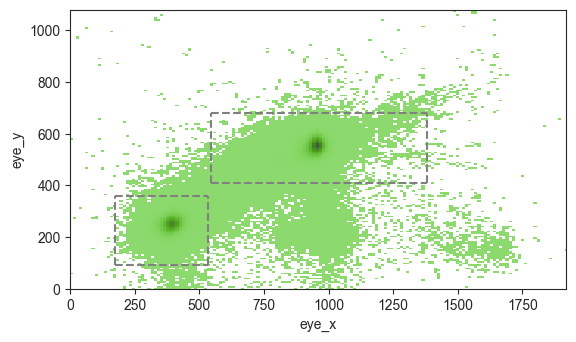

In [161]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
sns.histplot(data=data, x="eye_x", y="eye_y", ax=ax)
ax.set_xlim((0, 1920))
ax.set_ylim((0, 1080))
ax.hlines(y=[mirror_y_min, mirror_y_max], xmin=mirror_x_min, xmax=mirror_x_max, color="grey", ls='--')
ax.vlines(x=[mirror_x_min, mirror_x_max], ymin=mirror_y_min, ymax=mirror_y_max, color="grey", ls='--')

ax.hlines(y=[front_y_min, front_y_max], xmin=front_x_min, xmax=front_x_max, color="grey", ls='--')
ax.vlines(x=[front_x_min, front_x_max], ymin=front_y_min, ymax=front_y_max, color="grey", ls='--')

In [162]:
data.is_looking_at_mirror.value_counts()

is_looking_at_mirror
False    465017
True     345144
Name: count, dtype: int64

In [163]:
trial

,participant,trial,video,tta,d,time_budget,decision,RT,is_merge_decision,t,eye_x,eye_y,AOI,is_looking_at_mirror,is_looking_in_front,is_looking_elsewhere
0,3,1,10,6,30,6,Merge,1.515,True,0.00,667.90,640.50,front,False,True,False
1,3,1,10,6,30,6,Merge,1.515,True,0.05,663.80,637.85,front,False,True,False
2,3,1,10,6,30,6,Merge,1.515,True,0.10,810.75,714.35,other,False,False,True
3,3,1,10,6,30,6,Merge,1.515,True,0.15,810.30,704.65,other,False,False,True
4,3,1,10,6,30,6,Merge,1.515,True,0.20,811.90,703.00,other,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,3,1,10,6,30,6,Merge,1.515,True,5.65,309.10,252.85,mirror,True,False,False
114,3,1,10,6,30,6,Merge,1.515,True,5.70,306.30,249.20,mirror,True,False,False
115,3,1,10,6,30,6,Merge,1.515,True,5.75,305.30,251.05,mirror,True,False,False
116,3,1,10,6,30,6,Merge,1.515,True,5.80,304.60,251.85,mirror,True,False,False


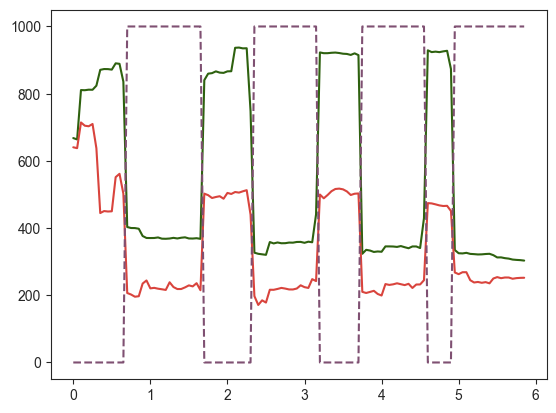

In [165]:
plt.plot(trial.t, trial.eye_x)
plt.plot(trial.t, trial.eye_y)
plt.plot(trial.t, (trial.AOI=="mirror")*1000, ls="--")

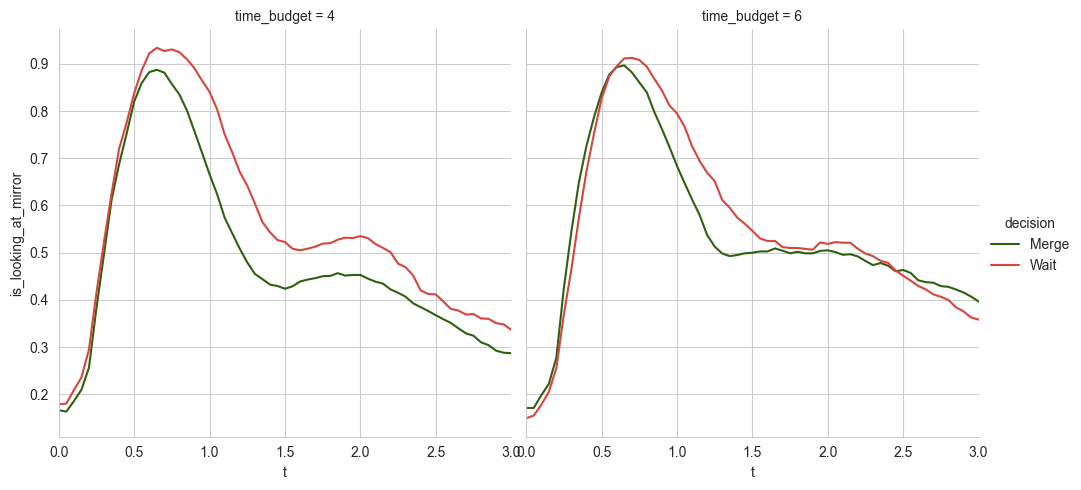

In [191]:
g = sns.relplot(
    data=data, kind="line", x="t", y="is_looking_at_mirror", 
    errorbar=None, hue="decision", col="time_budget",
)

for ax in g.axes.flatten():
    ax.set_xlim((0, 3))

In [7]:
def plot_average_gaze(data, ax):
    average_gaze = data.groupby(["t"])[["is_looking_at_mirror", "is_looking_in_front", "is_looking_elsewhere"]].mean().reset_index()
    ax.fill_between(average_gaze.t, np.zeros(len(average_gaze)), average_gaze.is_looking_at_mirror, alpha=0.4, color="C2", label="Mirror")
    ax.fill_between(average_gaze.t, average_gaze.is_looking_at_mirror, average_gaze.is_looking_at_mirror+average_gaze.is_looking_in_front, alpha=0.4, color="C3", label="Front")
    ax.fill_between(average_gaze.t, average_gaze.is_looking_at_mirror+average_gaze.is_looking_in_front, average_gaze.is_looking_at_mirror+average_gaze.is_looking_in_front+average_gaze.is_looking_elsewhere, alpha=0.4, color="C4", label="Other")
    median_rt = data.groupby(["participant", "trial"]).first().RT.mean() 
    # ax.vlines(x=median_rt, ymin=0, ymax=1, color="grey", ls="--", alpha=0.4, label="Mean RT")

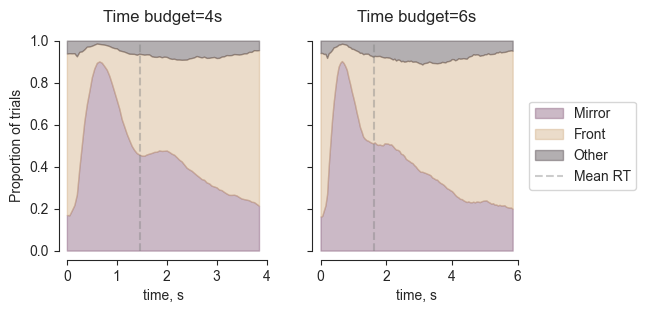

In [309]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), sharex=False, sharey=True)
plot_average_gaze(data[data.time_budget==4], ax1)
plot_average_gaze(data[data.time_budget==6], ax2)
ax1.set_title("Time budget=4s")
ax2.set_title("Time budget=6s")
ax1.set_xlabel("time, s")
ax2.set_xlabel("time, s")
ax1.set_ylabel("Proportion of trials")
ax2.legend(bbox_to_anchor=(1, 0.5), loc="center left")
sns.despine(trim=True, offset=-1)
plt.savefig("output/average_gaze.pdf", dpi=300, bbox_inches="tight")

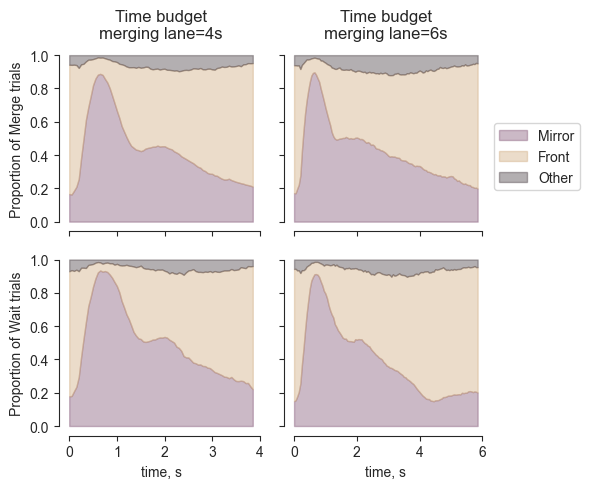

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,5), sharex="col", sharey="row")
plot_average_gaze(data[(data.decision=="Merge") &  (data.time_budget==4)], ax1)
plot_average_gaze(data[(data.decision=="Merge") & (data.time_budget==6)], ax2)
plot_average_gaze(data[(data.decision=="Wait") &  (data.time_budget==4)], ax3)
plot_average_gaze(data[(data.decision=="Wait") & (data.time_budget==6)], ax4)
ax1.set_title("Time budget\nmerging lane=4s", fontsize=12)
ax1.set_ylabel("Proportion of Merge trials")
ax2.set_title("Time budget\nmerging lane=6s", fontsize=12)
ax2.legend(bbox_to_anchor=(1., 0.4), loc="center left")
ax3.set_xlabel("time, s")
ax3.set_ylabel("Proportion of Wait trials")
ax4.set_xlabel("time, s")

sns.despine(trim=True, offset=1)
plt.tight_layout()
plt.savefig("output/average_gaze_by_decision.pdf", dpi=300, bbox_inches="tight")

# Time-based analyses   

## Mean probablity of merge decision

In [229]:
mean_p_merge = data.groupby(["is_looking_at_mirror", "t", "tta"]).is_merge_decision.mean().reset_index()

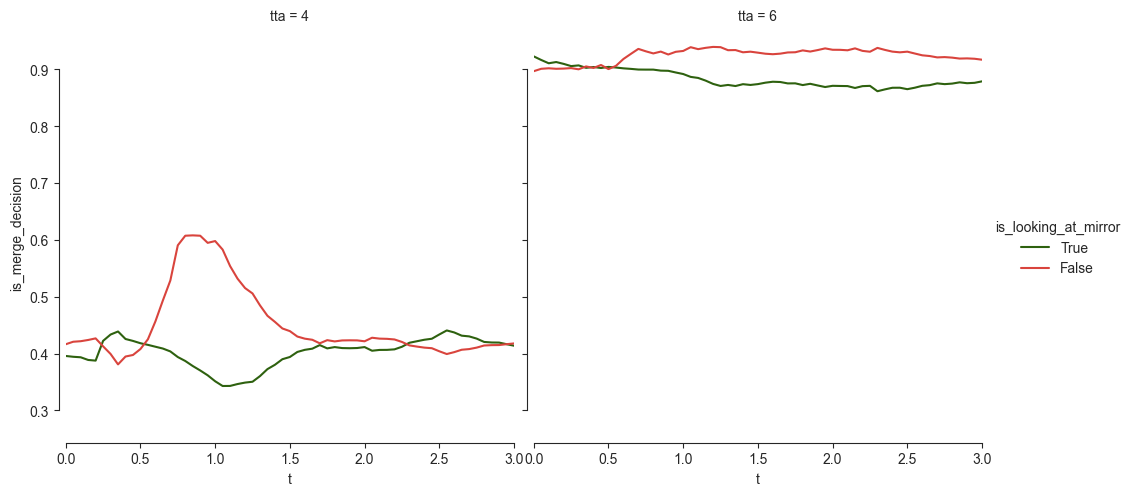

In [230]:
g = sns.relplot(data=mean_p_merge, x="t", y="is_merge_decision", hue="is_looking_at_mirror", col="tta", hue_order=[True, False], errorbar=None, kind="line")
for ax in g.axes.flatten():
    ax.set_xlim((0, 3))

# ax.fill_between(dataset.index, dataset.lower, dataset.upper, alpha=0.2)
sns.despine(trim=True, offset=5)

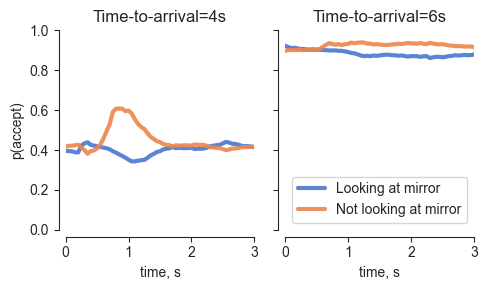

In [386]:
sns.set_palette(sns.color_palette("muted"))
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5, 3))
for tta, ax in zip([4, 6], axes):
    data_to_plot = mean_p_merge[(mean_p_merge.tta==tta)] 
    ax.plot(data_to_plot[data_to_plot.is_looking_at_mirror].t, data_to_plot[data_to_plot.is_looking_at_mirror].is_merge_decision, color="C0", alpha=0.9, lw=3, label="Looking at mirror")
    ax.plot(data_to_plot[~data_to_plot.is_looking_at_mirror].t, data_to_plot[~data_to_plot.is_looking_at_mirror].is_merge_decision, color="C1", alpha=0.9, lw=3, label="Not looking at mirror")
    ax.set_xlim((0, 3))
    ax.set_ylim((0, 1.0))

axes[0].set_title("Time-to-arrival=4s")
axes[0].set_ylabel("p(accept)")
axes[1].set_title("Time-to-arrival=6s")
axes[1].legend()
axes[0].set_xlabel("time, s")
axes[1].set_xlabel("time, s")

sns.despine(trim=True, offset=5)
plt.tight_layout()
plt.savefig("output/decision_vs_time.pdf", dpi=300, bbox_inches="tight")

In [310]:
def get_correlation(time_slice):
    # print(len(time_slice))
    return np.corrcoef(time_slice.is_looking_at_mirror, time_slice.is_merge_decision)[0][1]
corr = data.groupby(["tta", "t"]).apply(get_correlation).reset_index(name="corr")

In [311]:
corr

,tta,t,corr
0,4,0.00,-0.015407
1,4,0.05,-0.019778
2,4,0.10,-0.022243
3,4,0.15,-0.029063
4,4,0.20,-0.034844
...,...,...,...
231,6,5.65,0.000294
232,6,5.70,0.020735
233,6,5.75,0.005496
234,6,5.80,0.011223


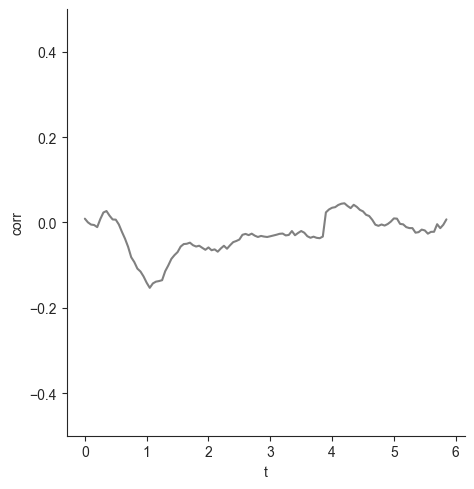

In [312]:
g = sns.relplot(data=corr, x="t", y="corr", color="grey", errorbar=None, kind="line")
for ax in g.axes.flatten():
    ax.set_ylim((-0.5, 0.5))

## Mean response times

In [352]:
mean_RTs = data.groupby(["decision", "is_looking_at_mirror", "t", "tta"]).RT.mean().reset_index()

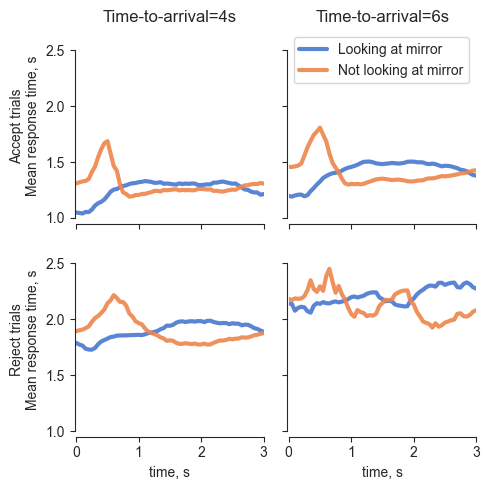

In [387]:
sns.set_palette(sns.color_palette("muted"))
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
for decision, ax_col in zip(["Merge", "Wait"], axes):
    for tta, ax in zip([4, 6], ax_col):
        data_to_plot = mean_RTs[(mean_RTs.tta==tta) & (mean_RTs.decision==decision)] 
        ax.plot(data_to_plot[data_to_plot.is_looking_at_mirror].t, data_to_plot[data_to_plot.is_looking_at_mirror].RT, color="C0", alpha=0.9, lw=3, label="Looking at mirror")
        ax.plot(data_to_plot[~data_to_plot.is_looking_at_mirror].t, data_to_plot[~data_to_plot.is_looking_at_mirror].RT, color="C1", alpha=0.9, lw=3, label="Not looking at mirror")
        ax.set_xlim((0, 3))

axes[0][0].set_title("Time-to-arrival=4s")
axes[0][0].set_ylabel("Accept trials\nMean response time, s")
axes[0][1].set_title("Time-to-arrival=6s")
axes[0][1].legend()
axes[1][0].set_xlabel("time, s")
axes[1][0].set_ylabel("Reject trials\nMean response time, s")
axes[1][1].set_xlabel("time, s")

sns.despine(trim=True, offset=1)
plt.tight_layout()
plt.savefig("output/mean_rt_vs_time.pdf", dpi=300, bbox_inches="tight")

In [377]:
sns.set_palette(palette, 5)

### Per participant

In [389]:
mean_RTs = data.groupby(["participant", "decision", "is_looking_at_mirror", "t", "tta"]).RT.mean().reset_index()

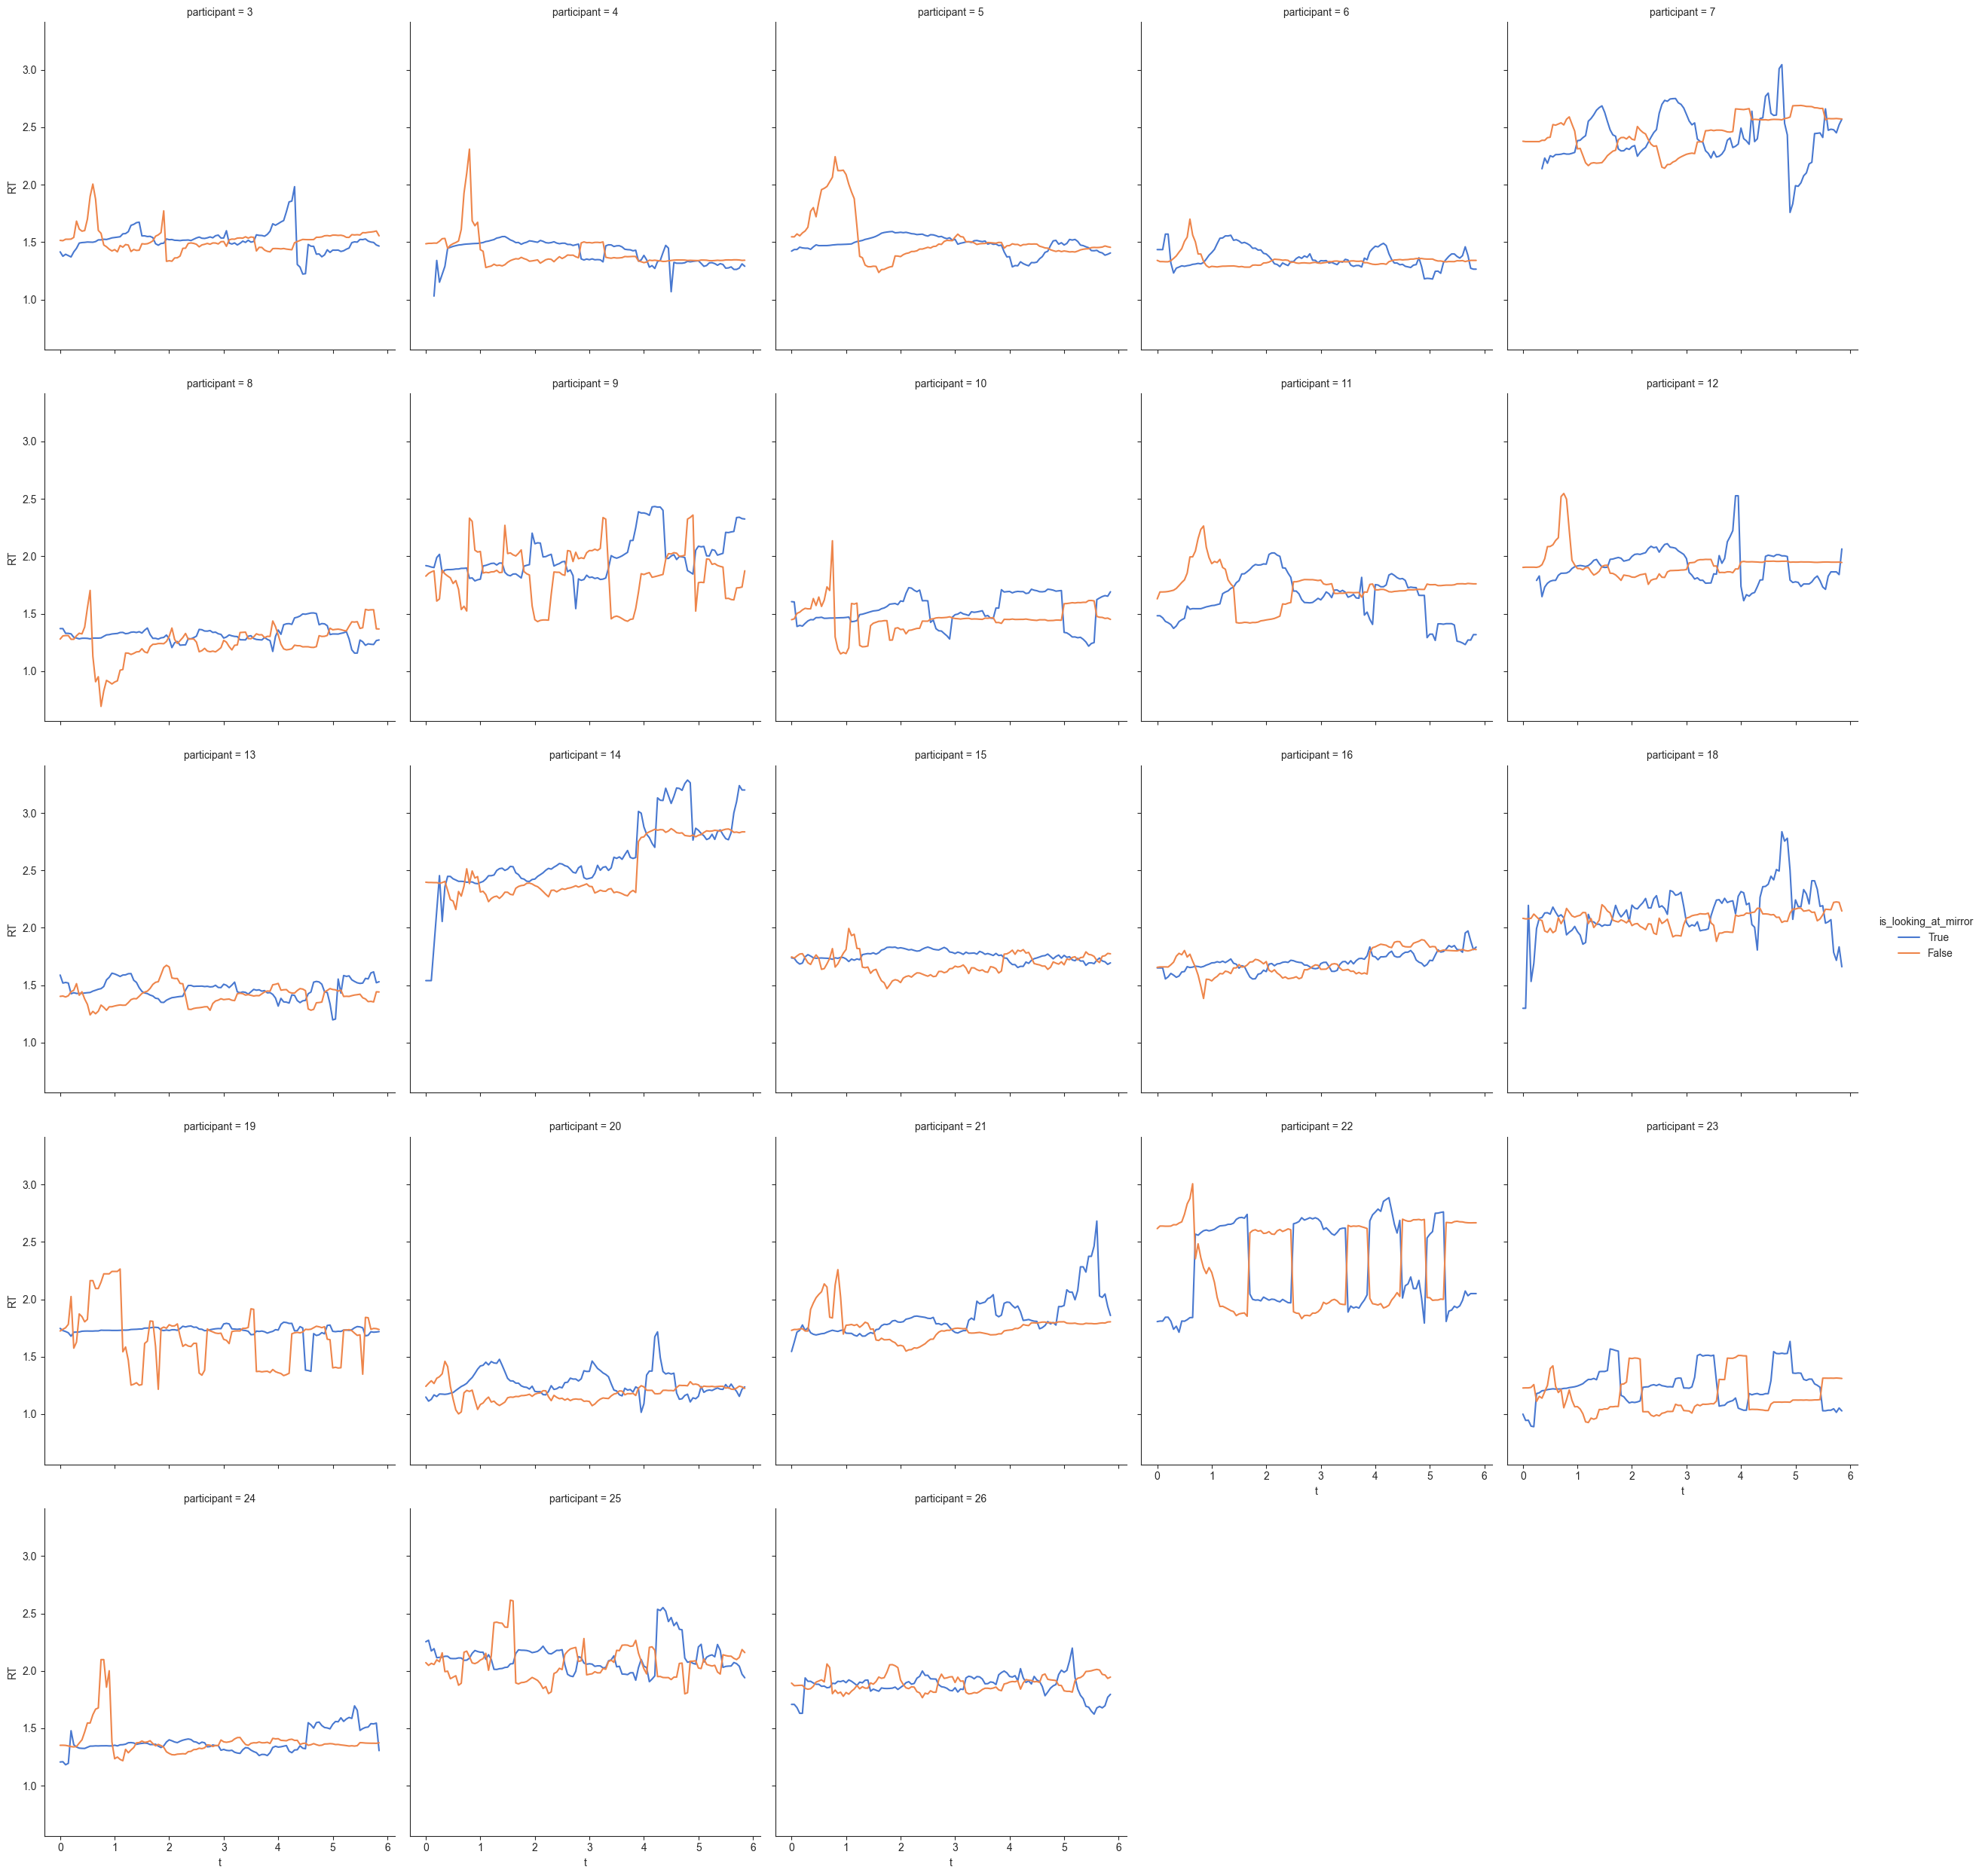

In [392]:
g = sns.relplot(data=mean_RTs, x="t", y="RT", hue="is_looking_at_mirror", hue_order=[True, False], col="participant", col_wrap=5, errorbar=None, kind="line")

# Calculating per-trial metrics

In [167]:
def get_trial_metrics(trial):
    dwell_mirror = len(trial[(trial.is_looking_at_mirror) & (trial.t<trial.RT.iloc[0])])/len(trial[trial.t<trial.RT.iloc[0]])
    looked_at_mirror_early = len(trial[(trial.is_looking_at_mirror) & (trial.t<0.3)]) > 0 
    return pd.Series({"dwell_mirror": dwell_mirror,
                      "looked_at_mirror_early": looked_at_mirror_early})    

In [168]:
get_trial_metrics(trial)

dwell_mirror              0.548387
looked_at_mirror_early       False
dtype: object

In [169]:
trial_metrics = (data.groupby(["participant", "trial"])
                    .apply(get_trial_metrics)
                    .join(data.groupby(["participant", "trial"]).first()[["tta", "d", "time_budget", "decision", "RT", "is_merge_decision"]])
                    .reset_index())

In [170]:
trial_metrics

,participant,trial,dwell_mirror,looked_at_mirror_early,tta,d,time_budget,decision,RT,is_merge_decision
0,3,1,0.548387,False,6,30,6,Merge,1.515,True
1,3,2,0.595238,False,4,40,6,Wait,2.100,False
2,3,3,0.614035,False,4,40,4,Wait,2.847,False
3,3,4,0.718750,False,6,40,6,Merge,1.596,True
4,3,5,0.314286,False,6,30,6,Merge,1.720,True
...,...,...,...,...,...,...,...,...,...,...
8270,26,356,0.590909,False,4,30,6,Merge,1.094,True
8271,26,357,0.464286,False,4,30,6,Merge,1.369,True
8272,26,358,0.645161,True,6,20,4,Merge,1.525,True
8273,26,359,0.478261,False,4,40,6,Merge,2.295,True


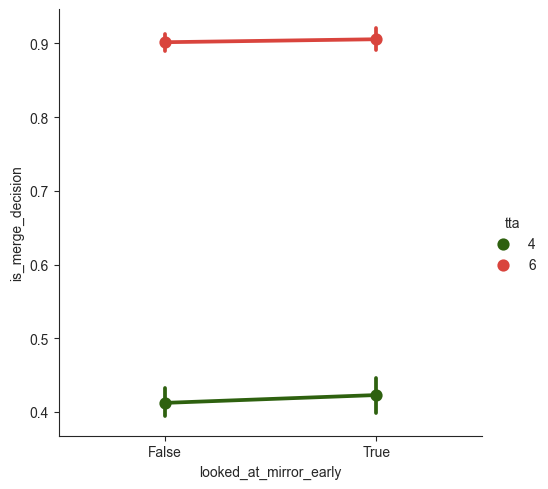

In [187]:
sns.catplot(data=trial_metrics, y="is_merge_decision", x="looked_at_mirror_early", hue="tta", kind="point")

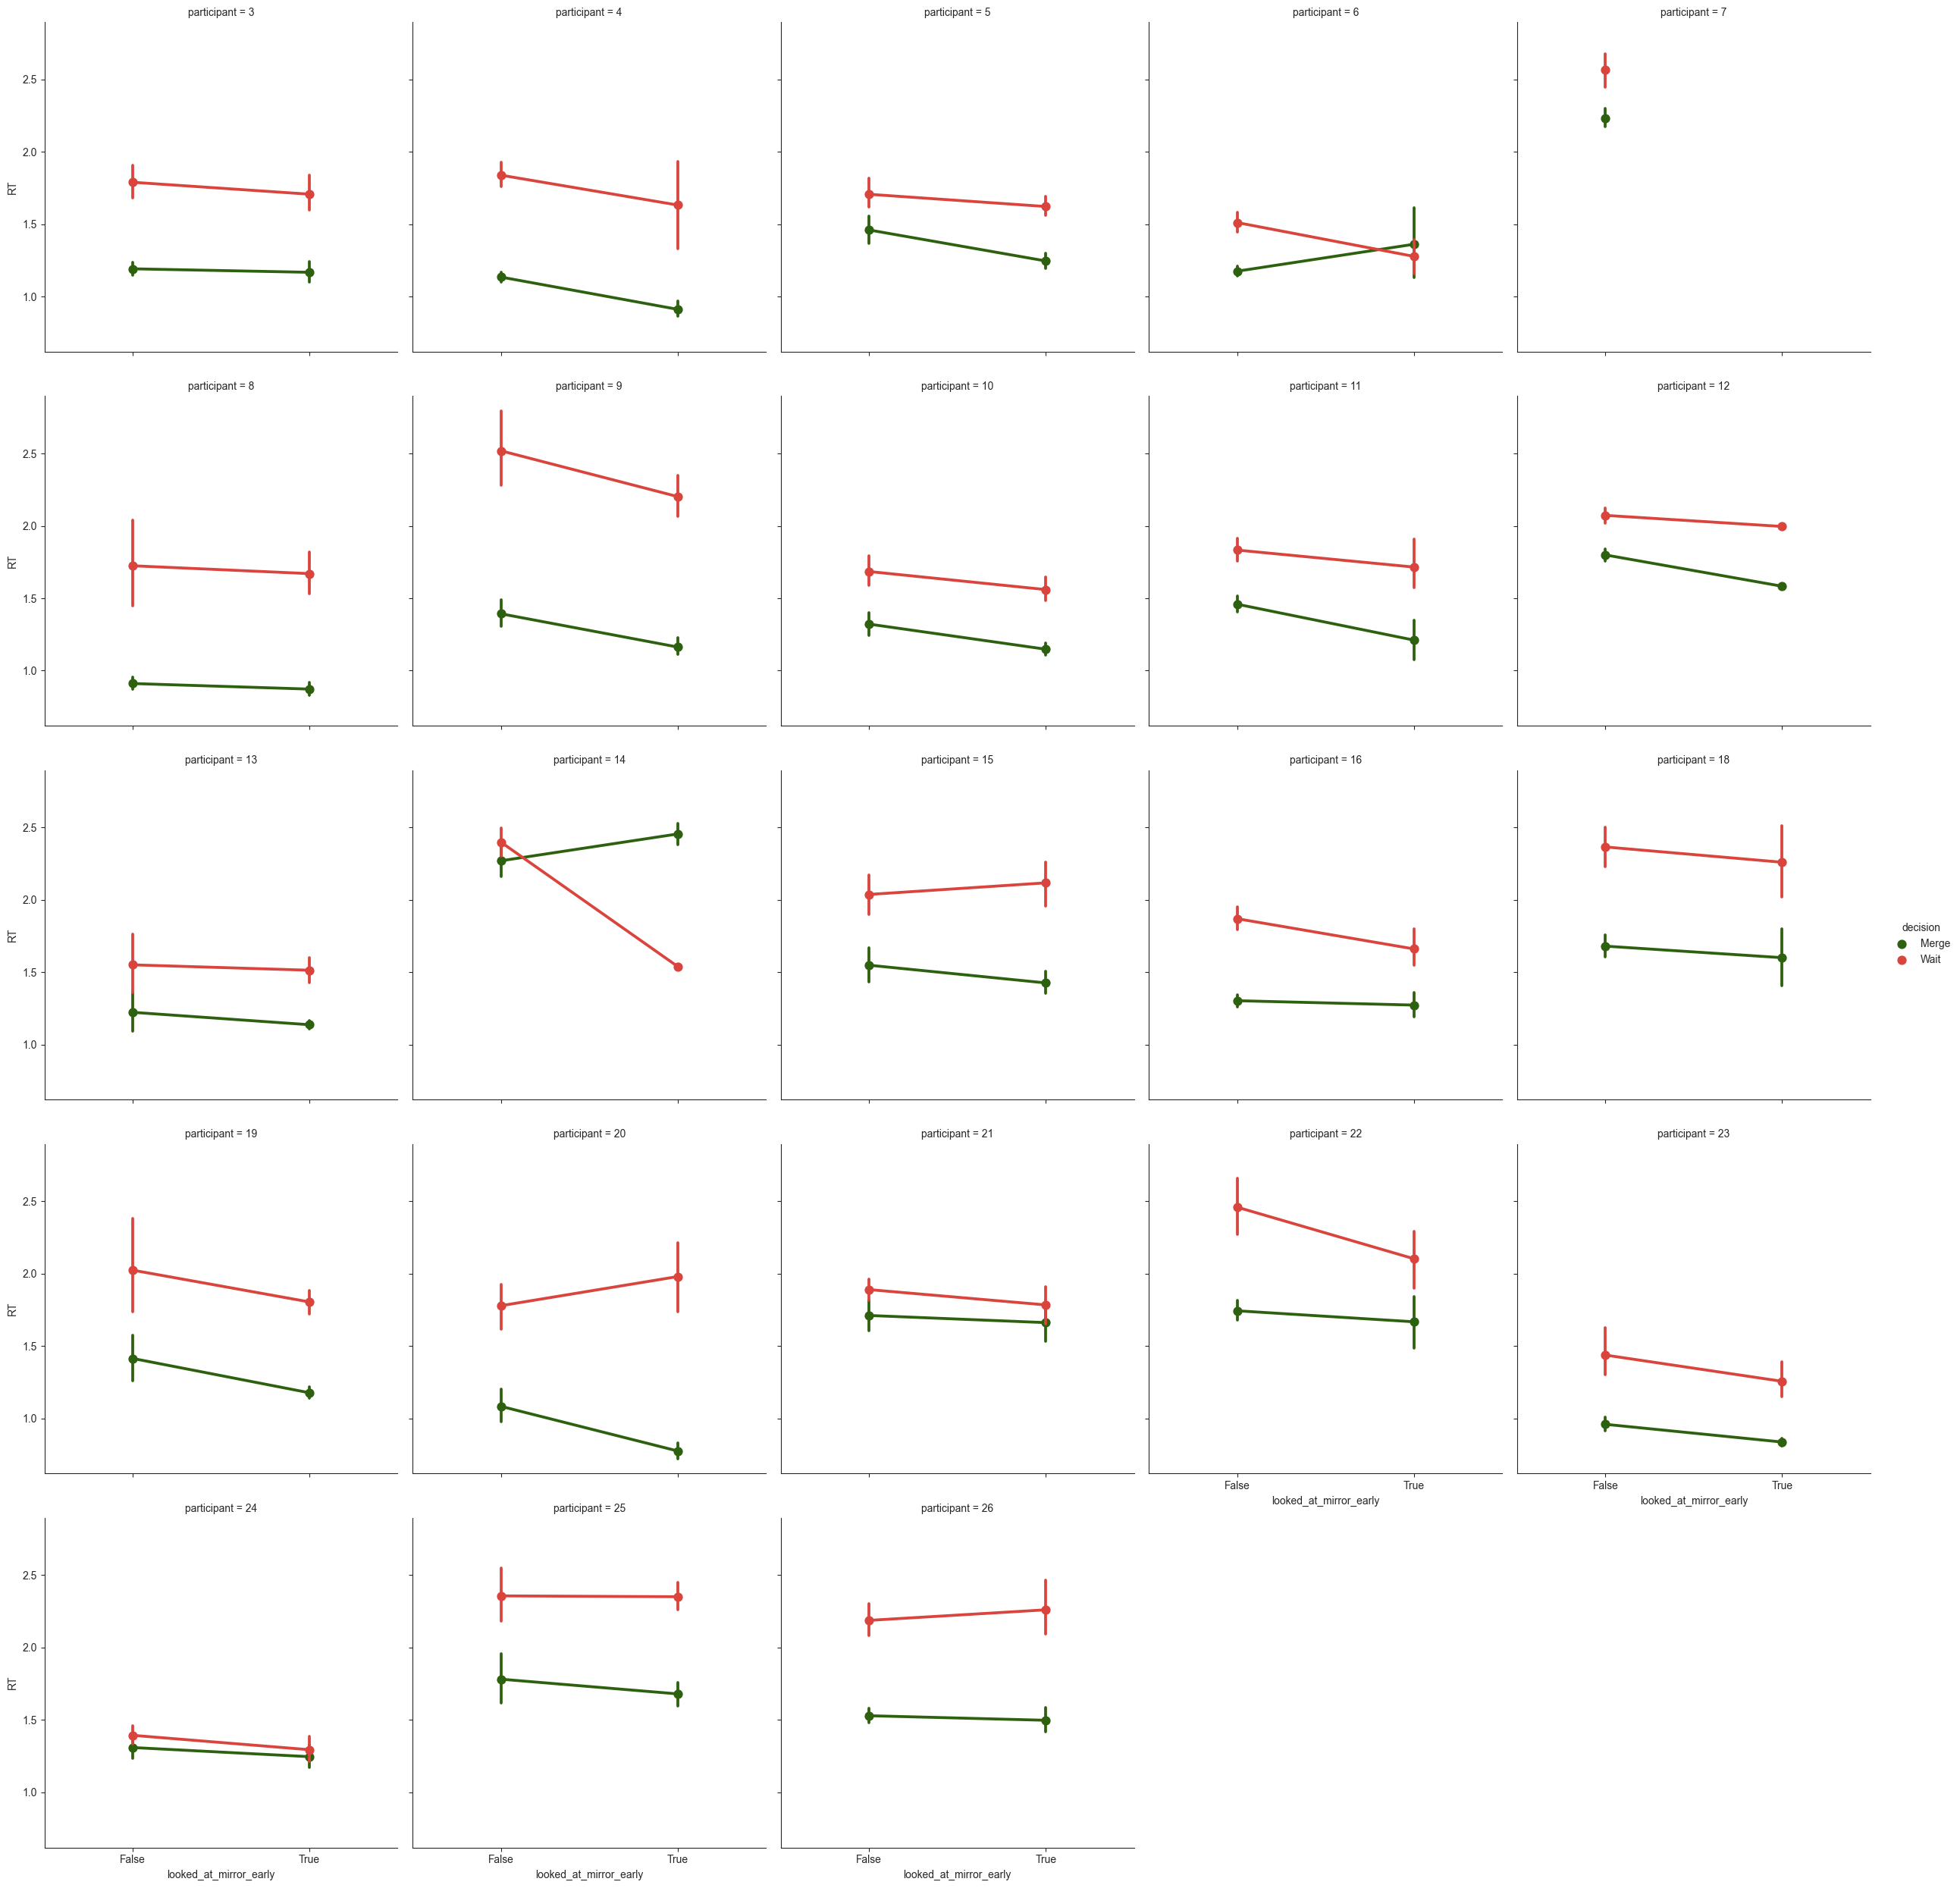

In [351]:
sns.catplot(data=trial_metrics, y="RT", x="looked_at_mirror_early", hue="decision", col="participant", col_wrap=5, kind="point")

In [317]:
trial_metrics

,participant,trial,dwell_mirror,looked_at_mirror_early,tta,d,time_budget,decision,RT,is_merge_decision
0,3,1,0.548387,False,6,30,6,Merge,1.515,True
1,3,2,0.595238,False,4,40,6,Wait,2.100,False
2,3,3,0.614035,False,4,40,4,Wait,2.847,False
3,3,4,0.718750,False,6,40,6,Merge,1.596,True
4,3,5,0.314286,False,6,30,6,Merge,1.720,True
...,...,...,...,...,...,...,...,...,...,...
8270,26,356,0.590909,False,4,30,6,Merge,1.094,True
8271,26,357,0.464286,False,4,30,6,Merge,1.369,True
8272,26,358,0.645161,True,6,20,4,Merge,1.525,True
8273,26,359,0.478261,False,4,40,6,Merge,2.295,True


In [321]:
participant_averages = trial_metrics.groupby(["participant", "tta"])[["is_merge_decision", "RT", "looked_at_mirror_early"]].mean().reset_index()

In [322]:
participant_averages

,participant,tta,is_merge_decision,RT,looked_at_mirror_early
0,3,4,0.561111,1.445961,0.222222
1,3,6,0.955556,1.210950,0.222222
2,4,4,0.494444,1.484894,0.105556
3,4,6,0.994444,1.101483,0.100000
4,5,4,0.073034,1.503590,0.685393
5,5,6,0.631285,1.552676,0.731844
6,6,4,0.744444,1.263833,0.050000
7,6,6,0.855556,1.223650,0.050000
8,7,4,0.605556,2.352261,0.000000
9,7,6,0.988889,2.252572,0.000000


## Individual differences

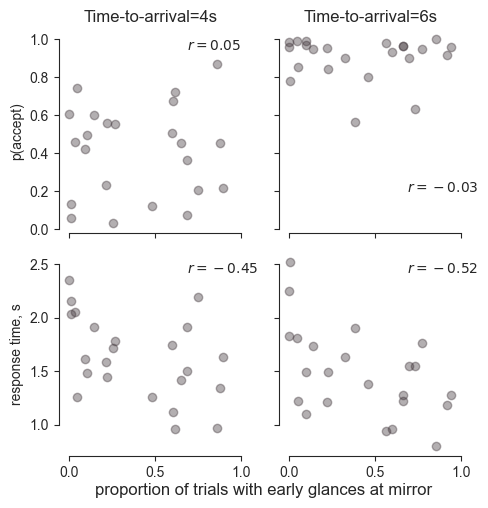

In [349]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey="row", figsize=(5, 5))

for tta, ax_row in zip([4, 6], axes.T):
    data_to_plot = participant_averages[participant_averages.tta==tta] 
    ax_row[0].scatter(data_to_plot.looked_at_mirror_early, data_to_plot.is_merge_decision, color="C4", alpha=0.4)        
    decision_r, decision_p = stats.pearsonr(data_to_plot.looked_at_mirror_early, data_to_plot.is_merge_decision)
    ax_row[0].annotate('$r= {:.2f}$'.format(decision_r), xy=(0.7, 0.9) if tta==4 else (0.7, 0.2), xycoords='axes fraction')
    
    ax_row[1].scatter(data_to_plot.looked_at_mirror_early, data_to_plot.RT, color="C4", alpha=0.4)
    rt_r, rt_p = stats.pearsonr(data_to_plot.looked_at_mirror_early, data_to_plot.RT)
    ax_row[1].annotate('$r= {:.2f}$'.format(rt_r), xy=(0.7, 0.9), xycoords='axes fraction')

for ax in axes.flatten():
    ax.set_xlim((-0.05, 1))
    
axes[0][0].set_title("Time-to-arrival=4s")
axes[0][0].set_ylabel("p(accept)")
axes[0][1].set_title("Time-to-arrival=6s")
axes[1][0].set_ylabel("response time, s")
fig.text(x=0.2, y=0.0, s="proportion of trials with early glances at mirror", fontsize=12)

sns.despine(trim=True, offset=1)
plt.tight_layout()
plt.savefig("output/individual_diffs.pdf", dpi=300, bbox_inches="tight")

# OBSOLETE: Reading the data from matlab files 

In [2]:
participant_dfs = []
for participant_id in range(1, 27):
    participant_df = pd.DataFrame(loadmat(file_name="eye_data/EyeTrackingData_Participant_%i.mat" % participant_id)["X"])[::100]
    participant_df.columns = ["trial", "video", "time", "eye_x", "eye_y", "AOI"]
    participant_df["participant"] = participant_id
    participant_dfs.append(participant_df)
    
data = pd.concat(participant_dfs)
data["trial"] = data["trial"].astype(int) 
data["video"] = data["video"].astype(int)
data["AOI"] = data["AOI"].astype(int)
data["p(looking in mirror)"] = data["AOI"] == 1
data["p(looking in front)"] = data["AOI"] == 2

In [82]:
data.to_csv("eye_data.csv")

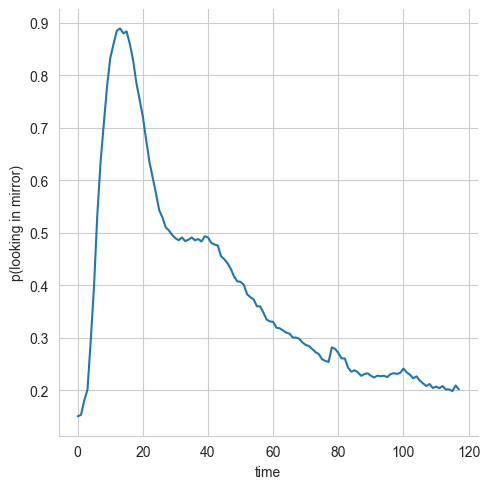

In [88]:
sns.relplot(
    data=data, kind="line", 
    x="time", y="p(looking in mirror)", errorbar=None,
)